In [3]:
# !wget https://raw.githubusercontent.com/huseinzol05/project-suka-suka/main/mysejahtera-density/data/Penang-points.json-points-cases.json
# https://pysal.org/esda/notebooks/adbscan_berlin_example.html

In [4]:
import json
import pandas as pd
import geopandas
from shapely.geometry import Point
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import contextily as cx

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
import warnings
import pandas
import numpy as np
from libpysal.cg.alpha_shapes import alpha_shape_auto
from scipy.spatial import cKDTree
from collections import Counter
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator as _BaseEstimator, ClusterMixin as _ClusterMixin

In [6]:
with open('Penang-points.json-points-cases.json') as fopen:
    data = json.load(fopen)
    
df = pd.DataFrame(data)
df.head()

,0,1,2
0,5.126404,100.397683,0
1,5.126404,100.401683,1
2,5.126404,100.405683,1
3,5.126404,100.409683,3
4,5.126404,100.413683,2


In [7]:
nonzero = df[2][df[2] > 0]
step = 0.05
arange = np.arange(0, 1.0 + step, step = step)
percentiles = np.percentile(nonzero, arange * 100)
percentiles

array([  1.,   1.,   1.,   1.,   2.,   2.,   3.,   3.,   4.,   6.,   7.,
         8.,   9.,  11.,  13.,  15.,  19.,  24.,  32.,  51., 141.])

In [8]:
boundaries = [percentiles[i: i + 2].tolist() for i in range(len(percentiles))][:-1]
boundaries = [[int(i[0]), int(i[1])] for i in boundaries]
boundaries[-1][-1] += 1
boundaries

[[1, 1],
 [1, 1],
 [1, 1],
 [1, 2],
 [2, 2],
 [2, 3],
 [3, 3],
 [3, 4],
 [4, 6],
 [6, 7],
 [7, 8],
 [8, 9],
 [9, 11],
 [11, 13],
 [13, 15],
 [15, 19],
 [19, 24],
 [24, 32],
 [32, 51],
 [51, 142]]

/home/ubuntu/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


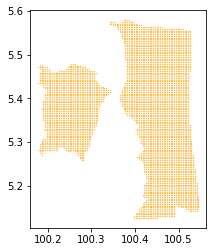

In [9]:
geometry = [Point(xy) for xy in zip(df[0], df[1])]
crs = {'init': 'epsg:4326'}
bl_gdf = GeoDataFrame(df, crs=crs, geometry=geopandas.points_from_xy(df[1], df[0]))
db = bl_gdf.to_crs(epsg=5243)
db.to_crs('crs').plot(markersize=0.1, color='orange')
db["X"] = db.geometry.x
db["Y"] = db.geometry.y

In [10]:
from libpysal.cg.alpha_shapes import alpha_shape_auto

def get_cluster_boundary(labels, xys, scores, xy=["X", "Y"], crs=None, step=1):
    try:
        from geopandas import GeoSeries
    except ModuleNotFoundError:

        def GeoSeries(data, index=None, crs=None):
            return list(data)

    lbl_type = type(labels.iloc[0])
    noise = lbl_type(-1)
    ids_in_cluster = labels[labels != noise].index
    g = xys.loc[ids_in_cluster, xy].groupby(labels[ids_in_cluster])
    polys = []
    cluster_lbls = []
    y, totals = [], []
    for sub in g.groups:
        try:
            polys.append(_asa((xys.loc[g.groups[sub], xy].values, 1)))
            y.append(scores.loc[g.groups[sub]].mean())
            totals.append(scores.loc[g.groups[sub]].shape[0])
            cluster_lbls.append(sub)
        except:
            pass
    polys = GeoSeries(polys, index=cluster_lbls, crs=crs)
    return polys, y, totals


def _asa(pts_s):
    return alpha_shape_auto(pts_s[0], step=pts_s[1])

In [11]:
from sklearn.cluster import DBSCAN

results = {}
color = {0: '#0000FF', 1: '#0000FF', 2: '#0000FF', 3: '#0000FF',
         4: '#0000FF', 5: '#0000FF', 6: '#0000FF', 7: '#FFFF00',
         8: '#FFFF00', 9: '#FFFF00', 10: '#FFFF00', 11: '#FFFF00',
         12: '#FFFF00', 13: '#FF0000', 14: '#FF0000', 15: '#FF0000',
         16: '#FF0000', 17: '#FF0000', 18: '#FF0000', 19: '#FF0000'}

already_processed = set()
for i in range(len(boundaries)):
    print(i, boundaries[i])
    
    if (boundaries[i][1] - boundaries[i][0]) < 1:
        continue
        
    if str(boundaries[i]) in already_processed:
        continue
        
    dbscan = DBSCAN(eps=0.005, min_samples=3)
    filtered_df = df[(df[2] >= boundaries[i][0]) & (df[2] < boundaries[i][1])]
    filtered_df_index = filtered_df.index
    clustering = dbscan.fit(filtered_df[[0,1]].values)

    labels = np.full(shape=df.shape[0], fill_value=-1)
    for no in range(len(clustering.labels_)):
        labels[filtered_df_index[no]] = clustering.labels_[no]
        
    print(np.unique(labels))
    
    polys, ys, totals = get_cluster_boundary(pd.Series(labels), db, db[2], crs=db.crs)
    polys = polys.to_crs('crs')

    polygons = []
    for k in range(len(polys)):
        polygons_ = []
        x, y = polys.iloc[k].exterior.coords.xy
        for x_, y_ in zip(x, y):
            polygons_.append({'lat': y_, 'lng': x_})
        polygons.append(polygons_)

    results[i] = {'polygons': polygons, 'data': [ys, totals], 'color': color[i]}
    already_processed.add(str(boundaries))

0 [1, 1]
1 [1, 1]
2 [1, 1]
3 [1, 2]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


4 [2, 2]
5 [2, 3]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


6 [3, 3]
7 [3, 4]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


8 [4, 6]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:628: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = (1 / radi) - EPS


9 [6, 7]
[-1  0  1  2  3  4  5  6  7  8]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


10 [7, 8]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


11 [8, 9]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


12 [9, 11]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


13 [11, 13]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


14 [13, 15]
[-1  0  1  2  3  4  5  6  7  8]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


15 [15, 19]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


16 [19, 24]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


17 [24, 32]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


18 [32, 51]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


19 [51, 142]
[-1  0  1  2  3  4  5  6  7  8  9]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


In [12]:
results.keys()

dict_keys([3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [13]:
with open('data/penang.json', 'w') as fopen:
    json.dump(results, fopen)